In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
index = pd.read_csv("./index.csv")
demographics = pd.read_csv("./demographics.csv")
epidemiology = pd.read_csv("./epidemiology.csv")

In [22]:
class COVID19Dataset(Dataset):
  def __init__(self, index, demographics, epidemiology):
    super().__init__()
    self.locations = set(index["location_key"].dropna())
    self.base_locations = ["TW", "US", "BR"]
    self.used_indices = []
    self.populations = []
    self.split = 0.7
    self.range = 14
    data = {}
    labels = {}
    populations = {}
    for loc, group in demographics.groupby("location_key"):
      data[loc] = group[group.columns[1:]].to_numpy()
    for loc, group in epidemiology.groupby("location_key"):
      if loc not in data: continue
      population = data[loc][0][0]
      if population == 0: continue
      history = (group[group.columns[2:]]).to_numpy() / population
      data[loc] = np.concatenate((data[loc].repeat(len(history), 0), history), 1) / population
      labels[loc] = (group[group.columns[2:]]["new_confirmed"]).to_numpy() / population
      data[loc] = np.nan_to_num(data[loc])
      labels[loc] = np.nan_to_num(labels[loc])
      populations[loc] = population
    for loc in [loc for loc in self.locations if len([0 for ul in self.base_locations if loc.startswith(ul)])]:
      if loc in data and loc in labels and int(len(data[loc]) * (1 - self.split)) > self.range: self.used_indices.append(loc)
    self.samples = [torch.tensor(data[loc], dtype=torch.float) for loc in self.used_indices]
    self.labels = [torch.tensor(labels[loc], dtype=torch.float) for loc in self.used_indices]
    self.populations = [populations[loc] for loc in self.used_indices]

  def __getitem__(self, loc):
    r = random.randint(self.range, int(len(self.samples[loc]) * self.split) - 1)
    return self.samples[loc][r - self.range:r], self.labels[loc][r]

  def get_validation(self):
    loc = random.randint(0, len(self.used_indices) - 1)
    r = random.randint(int(len(self.samples[loc]) * self.split) + self.range, len(self.samples[loc]) - 1)
    return self.samples[loc][r - self.range:r].unsqueeze(0), self.labels[loc][r].unsqueeze(0), self.populations[loc]

  def __len__(self): return len(self.used_indices)

In [14]:
BATCH_SIZE = 4
NUM_STEPS = 1000
NUM_VALID = 10000

In [23]:
dataset = COVID19Dataset(index, demographics, epidemiology)
torch.save(dataset, "./data/dataset.pt")
print(f"number of used locations: {len(dataset)}")

number of used locations: 8906


In [9]:
print(np.where(dataset.labels != 0))
print(dataset.labels[0][0])

(array([0], dtype=int64),)
tensor(0.)


In [24]:
dataset = torch.load("./data/dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [11]:
class Model(nn.Module):
  def __init__(self, r):
    self.r = r
    super().__init__()
    self.lstm = nn.LSTM(26, 256, 2, batch_first=True, bidirectional=True)
    self.seq = nn.Sequential(
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.3),
      nn.Linear(self.r * 256 * 2, 1024),
      nn.ReLU(True),
      nn.Linear(1024, 256),
      nn.ReLU(True),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, inputs):
    outputs, _ = self.lstm(inputs)
    outputs = self.seq(outputs)
    return outputs.squeeze(1)

In [42]:
print(next(iter(dataloader))[0].shape)
print(next(iter(dataloader))[1].shape)
print(next(iter(dataloader))[1])

torch.Size([4, 84, 26])
torch.Size([4])
tensor([1.7819e-04, 0.0000e+00, 1.7989e-04, 7.5959e-05])


In [55]:
loss_fn = nn.MSELoss()
model = Model(dataset.range)
samples, labels = next(iter(dataloader))
outputs = model(samples)
loss = torch.sqrt(loss_fn(outputs, labels))
print(labels)
print(outputs)
print(loss.item())

tensor([0.0000e+00, 0.0000e+00, 9.6441e-05, 0.0000e+00])
tensor([0.5049, 0.5047, 0.5048, 0.5044], grad_fn=<SqueezeBackward1>)
0.5046453475952148


100/1000:	0.2426
200/1000:	0.0004
300/1000:	0.0003
400/1000:	0.0003
500/1000:	0.0003
600/1000:	0.0003
700/1000:	0.0003
800/1000:	0.0004
900/1000:	0.0004
1000/1000:	0.0002
Training Ended!


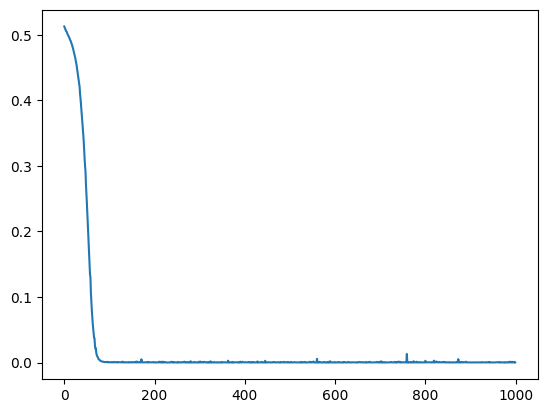

In [19]:
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(dataset.range)
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
loss_fn = nn.MSELoss()
losses = []

model.train()

if device == "cuda": model.cuda()
for step in range(1, NUM_STEPS + 1):
  optimizer.zero_grad()
  samples, labels = next(iter(dataloader))
  outputs = model(samples.to(device))
  loss = torch.sqrt(loss_fn(outputs.to(device), labels.to(device)))
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  if step % 100 == 0:
    print(f"{step}/{NUM_STEPS}:\t{np.mean(losses[step - 100:step]):.4f}")

plt.plot(losses)
print("Training Ended!")

unacceptable cases: 885
mean error rate: -0.0002


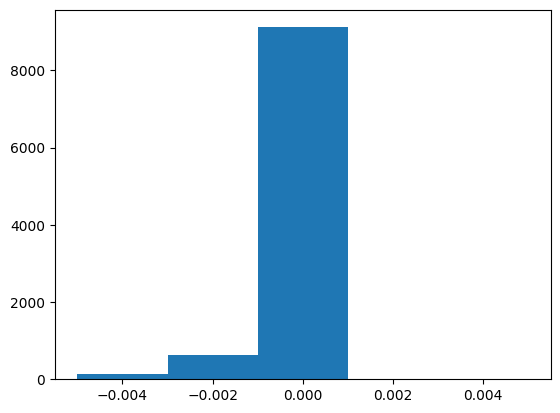

In [26]:
unacceptable = 0
error_rate_sum = 0

log = False
error_rates = []

with torch.no_grad():
  for step in range(1, NUM_VALID + 1):
    samples, labels, population = dataset.get_validation()
    outputs = model(samples.to(device))
    error_rate = (outputs - labels.to(device)).item()
    error = int(error_rate * population)
    error_rates.append(error_rate)
    if abs(error_rate) < 1e-3: continue
    unacceptable += 1
    error_rate_sum += error_rate
    if not log: continue
    print(f"population: {int(population)}")
    print(f"predict: {outputs.item():.4f}")
    print(f"reality: {labels.item():.4f}")
    print(f"error rate: {error_rate:.4f}")
    print(f"error: {error}")

plt.hist(error_rates, [-np.inf, -5e-3, -3e-3, -1e-3, 1e-3, 3e-3, 5e-3, np.inf])

print(f"unacceptable cases: {unacceptable}")
print(f"mean error rate: {error_rate_sum / NUM_VALID:.4f}")

In [19]:
unacceptable = 0
error_rate_sum = 0
num_samples = 10

log = False

with torch.no_grad():
  for step in range(1, NUM_VALID + 1):
    samples, labels, population = dataset.get_validation()
    outputs = torch.zeros((1, 1)).to(device)
    for _ in range(num_samples): outputs += model(samples.to(device))
    outputs /= num_samples
    error_rate = (outputs - labels.to(device)).item()
    error = int(error_rate * population)
    if abs(error_rate) < 1e-3: continue
    unacceptable += 1
    error_rate_sum += error_rate
    if not log: continue
    print(f"population: {int(population)}")
    print(f"predict: {outputs.item():.4f}")
    print(f"reality: {labels.item():.4f}")
    print(f"error rate: {error_rate:.4f}")
    print(f"error: {error}")

print(f"unacceptable cases: {unacceptable}")
print(f"mean error rate: {error_rate_sum / NUM_VALID:.4f}")

unacceptable cases: 90
mean error rate: -0.0002
